# Convex Burgers' Equation 1D_Finite Difference Schemes

$$ \partial _{t}u + H\left ( \partial _{x}u \right ) =0 \quad u(x,0)=u_{0}(x) \quad \text{for } t>0 \text{ , } x \in \left [ a , b \right ]$$  
- $\Omega = [-1 , 1[$
- $u(x,0) = -cos(\pi x)$
- $H$ Convex  
- $H(p)=\frac{(p+\alpha )^{2}}{2}$
- $\partial _{p} H=p+\alpha$
- Viscosity solution (Hopf-Lax formula) : $u(x,t)=\underset{y \in \Omega}{inf} \left \{ \frac{(x-y)^{2}}{2t}-cos(\pi y) \right \}$

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 

## Initial condition

Text(0, 0.5, '$u_0(x)$')

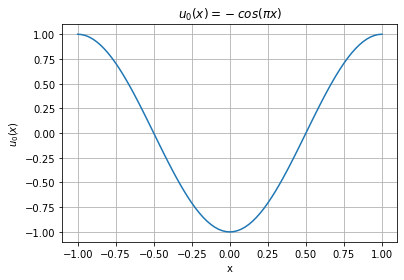

In [2]:
X= np.linspace(-1,1,81) # creating the space grid    
U0 = np.zeros(81)
for i in range(len(X)):
    U0[i] = - math.cos(math.pi*X[i]) 
plt.plot(X,U0)
plt.grid()
plt.title("$u_0(x)=-cos(\pi x)$")
plt.xlabel('x')
plt.ylabel("$u_0(x)$") 

## Viscosity solution

Text(0, 0.5, '$u(x,t)$')

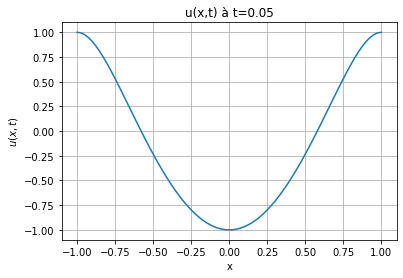

In [3]:
def f(x,y,t):
    return ((x-y)**2)/(2*t)-math.cos(math.pi*y)

def U(x,t):
    min_value = 1
    for y in np.linspace(-1,1,1001):
        if f(x,min_value,t) > f(x,y,t): min_value = y
    return f(x,min_value,t)

X= np.linspace(-1,1,81) # creating the space grid 
tf=0.5/math.pi**2
Uex = np.zeros(81)
for i in range(len(X)):
    Uex[i] = U(X[i],tf) 
plt.plot(X,Uex)
plt.grid()
plt.title("u(x,t) à t=%1.2f" %tf)
plt.xlabel('x')
plt.ylabel("$u(x,t)$") 

## Numerical Hamiltonian

In [4]:
# Convex Burgers' equation
alpha = 0.0
def H(p):
    return 0.5*(p+alpha)**2

def max_H(p1,p2):
    a, b = min(p1,p2), max(p1,p2)
    max_value = b
    for x in np.linspace(a,b,1001):
        if H(max_value) < H(x): max_value = x
    return H(max_value)
    
def min_H(p1,p2):
    a, b = min(p1,p2), max(p1,p2)
    min_value = b
    for x in np.linspace(a,b,1001):
        if H(min_value) > H(x): min_value = x
    return H(min_value)

# H'(p)
def dpH(p):
    return p+alpha

# min-max of H'(p) in [a,b]
def max_abs_dpH(p1,p2):
    a, b = min(p1,p2), max(p1,p2)
    max_value = b
    for x in np.linspace(a,b,1001):
        if abs(dpH(max_value)) < abs(dpH(x)): max_value = x
    return abs(dpH(max_value))
    
def min_abs_dpH(p1,p2):
    a, b = min(p1,p2), max(p1,p2)
    min_value = b
    for x in np.linspace(a,b,1001):
        if abs(dpH(min_value)) > abs(dpH(x)): min_value = x
    return abs(dpH(min_value))

def max_dpH(p1,p2):
    a, b = min(p1,p2), max(p1,p2)
    max_value = b
    for x in np.linspace(a,b,1001):
        if dpH(max_value) < dpH(x): max_value = x
    return dpH(max_value)
    
def min_dpH(p1,p2):
    a, b = min(p1,p2), max(p1,p2)
    min_value = b
    for x in np.linspace(a,b,1001):
        if dpH(min_value) > dpH(x): min_value = x
    return dpH(min_value)



#************************** First-order monotone schemes *************

# Upwind 
def H_upwind(p1,p2):  #p1=p-,p2=p+
    if dpH(p1)<=0:
        return H(p2)
    else: return H(p1)

# Local-Lax-Friedrichs
def H_lax(p1,p2,alpha_x):   #p1=p-,p2=p+
    return H(0.5*(p1+p2))-0.5*alpha_x*(p2-p1)

# Godunov    
def H_godunov(p1,p2):    #p1=p-,p2=p+
    if p1<=p2: 
        return min_H(p1,p2)
    else: 
        return max_H(p1,p2)

# Roe with LLF entropy correction
def H_Roe(p1,p2,alpha_x):   #p1=p-,p2=p+
    if min_dpH(p1,p2)*max_dpH(p1,p2)>=0.0:   
        return H_upwind(p1,p2) 
    else: return H_lax(p1,p2,alpha_x)

## slope reconstruction

In [5]:
def P_deg1(u1,u2,dx):
       # For p- : u1=u[i-1] , u2=u[i]
       # For p+ : u1=u[i] , u2=u[i+1]
    return (u2-u1)/dx

#************************* TVD Method ********************
def P_TVD2(u1,u2,dx):
       # For p- and p+ : u1=u[i-1] , u2=u[i+1]
    return (u2-u1)/(2*dx)

def P_TVD3(u1,u2,u3,u4,dx):
       # For p- : u1=u[i-2] , u2=u[i-1] , u3=u[i] , u4=u[i+1]
       # For p+ : u1=-u[i+2] , u2=-u[i+1] , u3=-u[i] , u4=-u[i-1]
    return ((u1/6)-u2+(u3/2)+(u4/3))/dx

#************************ ENO Schemes ********************************
def Pm_ENO2(u1,u2,u3,u4,dx):
# For p- : u1=u[i-2] , u2=u[i-1] , u3=u[i] , u4=u[i+1]
    CL=(u3-2*u2+u1)/(2*(dx**2))
    CR=(u4-2*u3+u2)/(2*(dx**2))
    if abs(CL)<abs(CR):
        return P_deg1(u2,u3,dx)+dx*CL
    else:
        return P_deg1(u2,u3,dx)+dx*CR

def Pp_ENO2(u1,u2,u3,u4,dx):
# For p+ : u1=u[i-1] , u2=u[i] , u3=u[i+1] , u4=u[i+2]
    CL=(u3-2*u2+u1)/(2*(dx**2))
    CR=(u4-2*u3+u2)/(2*(dx**2))
    if abs(CL)<abs(CR):
        return P_deg1(u2,u3,dx)-dx*CL
    else:
        return P_deg1(u2,u3,dx)-dx*CR
    
def Pm_ENO3(u1,u2,u3,u4,u5,u6,dx):
# For p- : u1=u[i-3] , u2=u[i-2] , u3=u[i-1] , u4=u[i] ,u5=u[i+1] , u6=u[i+2]
    Ca=(u4-3*u3+3*u2-u1)/(6*(dx**3))
    Cb=(u6-3*u5+3*u4-u3)/(6*(dx**3))
    Cc=(u5-3*u4+3*u3-u2)/(6*(dx**3))
    CL=(u4-2*u3+u2)/(2*(dx**2))
    CR=(u5-2*u4+u3)/(2*(dx**2))
    if abs(CL)<abs(CR) and abs(Ca)<abs(Cc):
        return Pm_ENO2(u2,u3,u4,u5,dx)+2*(dx**2)*Ca
    if abs(CL)>abs(CR) and abs(Cc)>abs(Cb):
        return Pm_ENO2(u2,u3,u4,u5,dx)-(dx**2)*Cb
    else:
        return Pm_ENO2(u2,u3,u4,u5,dx)-(dx**2)*Cc
        
def Pp_ENO3(u1,u2,u3,u4,u5,u6,dx):
# For p+ : u1=u[i-2] , u2=u[i-1] , u3=u[i] , u4=u[i+1] ,u5=u[i+2] , u6=u[i+3]
    Ca=(u4-3*u3+3*u2-u1)/(6*(dx**3))
    Cb=(u6-3*u5+3*u4-u3)/(6*(dx**3))
    Cc=(u5-3*u4+3*u3-u2)/(6*(dx**3))
    CL=(u4-2*u3+u2)/(2*(dx**2))
    CR=(u5-2*u4+u3)/(2*(dx**2))
    if abs(CL)<abs(CR) and abs(Ca)<abs(Cc):
        return Pp_ENO2(u2,u3,u4,u5,dx)-(dx**2)*Ca
    if abs(CL)>abs(CR) and abs(Cc)>abs(Cb):
        return Pp_ENO2(u2,u3,u4,u5,dx)+2*(dx**2)*Cb
    else:
            return Pp_ENO2(u2,u3,u4,u5,dx)+2*(dx**2)*Cc
        

#************************ WENO Schemes ********************************
def phi_WENO(a,b,c,d,epsilon):
    ISa=13*(a-b)**2+3*(a-3*b)**2
    ISb=13*(c-d)**2+3*(3*c-d)**2
    ISc=13*(b-c)**2+3*(b+c)**2
    alpha_a=1/((epsilon+ISa)**2)
    alpha_b=3/((epsilon+ISb)**2)
    alpha_c=6/((epsilon+ISc)**2)
    omega_a=alpha_a/(alpha_a+alpha_b+alpha_c)
    omega_b=alpha_b/(alpha_a+alpha_b+alpha_c)
    
    return omega_a*(a-2*b+c)/3+(omega_b-0.5)*(b-2*c+d)/6

def Pm_WENO3(u1,u2,u3,u4,u5,u6,dx):
# For p- : u1=u[i-3] , u2=u[i-2] , u3=u[i-1] , u4=u[i] ,u5=u[i+1] , u6=u[i+2]
    p1=P_deg1(u1,u2,dx)
    p2=P_deg1(u2,u3,dx)
    p3=P_deg1(u3,u4,dx)
    p4=P_deg1(u4,u5,dx)
    p5=P_deg1(u5,u6,dx)
    a=p2-p1
    b=p3-p2
    c=p4-p3
    d=p5-p4
    return (-p2+7*p3+7*p4-p5)/12-phi_WENO(a,b,c,d,1.e-6)

def Pp_WENO3(u1,u2,u3,u4,u5,u6,dx):
# For p+ : u1=u[i-2] , u2=u[i-1] , u3=u[i] , u4=u[i+1] ,u5=u[i+2] , u6=u[i+3]
    p1=P_deg1(u1,u2,dx)
    p2=P_deg1(u2,u3,dx)
    p3=P_deg1(u3,u4,dx)
    p4=P_deg1(u4,u5,dx)
    p5=P_deg1(u5,u6,dx)
    a=p5-p4
    b=p4-p3
    c=p3-p2
    d=p2-p1
    return (-p1+7*p2+7*p3-p4)/12+phi_WENO(a,b,c,d,1.e-6)

## Numerical Schemes

In [6]:
def frst_schemes(u1, u2, u3, nx, dx, dt, grid, error1, error2, error3):

    t=0.0
    un1 = np.zeros(nx)
    un2 = np.zeros(nx)
    un3 = np.zeros(nx)
    
    while True:
        
        uex = np.zeros(nx)
        for i in range(len(grid)):
            if t==0.0:
                uex[i]=- math.cos(math.pi*grid[i])
            else: 
                uex[i] = U(grid[i],t)
        
        for i in range(nx):
            un1[i] = u1[i]
            un2[i] = u2[i]
            un3[i] = u3[i]
            
        for i in range(1,nx-1):
            # p1:p- , p2:p+
            p1_lax= P_deg1(un1[i-1],un1[i],dx)
            p2_lax= P_deg1(un1[i],un1[i+1],dx)
            p1_go= P_deg1(un2[i-1],un2[i],dx)
            p2_go= P_deg1(un2[i],un2[i+1],dx)
            p1_roe= P_deg1(un3[i-1],un3[i],dx)
            p2_roe= P_deg1(un3[i],un3[i+1],dx)

            alpha_x1=max_abs_dpH(p1_lax,p2_lax)
            alpha_x3=max_abs_dpH(p1_roe,p2_roe)
            
            u1[i]=un1[i]-dt*H_lax(p1_lax,p2_lax,alpha_x1)
            u2[i]=un2[i]-dt*H_godunov(p1_go,p2_go)
            u3[i]=un3[i]-dt*H_Roe(p1_roe,p2_roe,alpha_x3)
        
        err1= np.linalg.norm(uex-u1,ord=2)/np.linalg.norm(uex,ord=2) 
        err2= np.linalg.norm(uex-u2,ord=2)/np.linalg.norm(uex,ord=2) 
        err3= np.linalg.norm(uex-u3,ord=2)/np.linalg.norm(uex,ord=2) 
        
        error1.append(err1)
        error2.append(err2)
        error3.append(err3)
        
        t += dt
        t = min(t,tf)
        if t >= tf:
            break  
    return 0

def TVD_deg2(v1, v2, v3, nx, dx, dt, grid, error1_TVD2, error2_TVD2, error3_TVD2):

    t=0.0
    vn1 = np.zeros(nx)
    vn2 = np.zeros(nx)
    vn3 = np.zeros(nx)
    
    while True:
        
        vex = np.zeros(nx)
        for i in range(len(grid)):
            if t==0.0:
                vex[i]=- math.cos(math.pi*grid[i])
            else: 
                vex[i] = U(grid[i],t)
                
        for i in range(nx):
            vn1[i] = v1[i]
            vn2[i] = v2[i]
            vn3[i] = v3[i]
            
        for i in range(1,nx-1):
            p_lax= P_TVD2(vn1[i-1],vn1[i+1],dx)
            p_go= P_TVD2(vn2[i-1],vn2[i+1],dx)
            p_roe= P_TVD2(vn3[i-1],vn3[i+1],dx)

            alpha_x1=abs(dpH(p_lax))
            alpha_x3=abs(dpH(p_roe))
            
            v1[i]=vn1[i]-dt*H_lax(p_lax,p_lax,alpha_x1)
            v2[i]=vn2[i]-dt*H_godunov(p_go,p_go)
            v3[i]=vn3[i]-dt*H_Roe(p_roe,p_roe,alpha_x3)
        
        err1= np.linalg.norm(vex-v1,ord=2)/np.linalg.norm(vex,ord=2)   
        err2= np.linalg.norm(vex-v2,ord=2)/np.linalg.norm(vex,ord=2) 
        err3= np.linalg.norm(vex-v3,ord=2)/np.linalg.norm(vex,ord=2) 
        
        error1_TVD2.append(err1)
        error2_TVD2.append(err2)
        error3_TVD2.append(err3)
        
        t += dt
        t = min(t,tf)
        if t >= tf:
            break  
    return 0

def TVD_deg3(w1, w2, w3, nx, dx, dt, grid, error1_TVD3, error2_TVD3, error3_TVD3):

    t=0.0
    wn1 = np.zeros(nx)
    wn2 = np.zeros(nx)
    wn3 = np.zeros(nx)
    
    while True:
        
        wex = np.zeros(nx)
        for i in range(len(grid)):
            if t==0.0:
                wex[i]=- math.cos(math.pi*grid[i])
            else: 
                wex[i] = U(grid[i],t)
                
        for i in range(nx):
            wn1[i] = w1[i]
            wn2[i] = w2[i]
            wn3[i] = w3[i]

        for i in range(2,nx-2):
            p1_lax= P_TVD3(wn1[i-2],wn1[i-1],wn1[i],wn1[i+1],dx)
            p2_lax= P_TVD3(-wn1[i+2],-wn1[i+1],-wn1[i],-wn1[i-1],dx)
            p1_go= P_TVD3(wn2[i-2],wn2[i-1],wn2[i],wn2[i+1],dx)
            p2_go= P_TVD3(-wn2[i+2],-wn2[i+1],-wn2[i],-wn2[i-1],dx)
            p1_roe= P_TVD3(wn3[i-2],wn3[i-1],wn3[i],wn3[i+1],dx)
            p2_roe= P_TVD3(-wn3[i+2],-wn3[i+1],-wn3[i],-wn3[i-1],dx)

            alpha_x1=max_abs_dpH(p1_lax,p2_lax)
            alpha_x3=max_abs_dpH(p1_roe,p2_roe)
            
            w1[i]=wn1[i]-dt*H_lax(p1_lax,p2_lax,alpha_x1)
            w2[i]=wn2[i]-dt*H_godunov(p1_go,p2_go)
            w3[i]=wn3[i]-dt*H_Roe(p1_roe,p2_roe,alpha_x3)
        
        err1= np.linalg.norm(wex-w1,ord=2)/np.linalg.norm(wex,ord=2)   
        err2= np.linalg.norm(wex-w2,ord=2)/np.linalg.norm(wex,ord=2) 
        err3= np.linalg.norm(wex-w3,ord=2)/np.linalg.norm(wex,ord=2) 
        
        error1_TVD3.append(err1)
        error2_TVD3.append(err2)
        error3_TVD3.append(err3)
        
        t += dt
        t = min(t,tf)
        if t >= tf:
            break  
    return 0

def ENO_deg2(y1, y2, y3, nx, dx, dt, grid, error1_ENO2, error2_ENO2, error3_ENO2):

    t=0.0
    yn1 = np.zeros(nx)
    yn2 = np.zeros(nx)
    yn3 = np.zeros(nx)
    
    while True:
        yex = np.zeros(nx)
        for i in range(len(grid)):
            if t==0.0:
                yex[i]=- math.cos(math.pi*grid[i])
            else: 
                yex[i] = U(grid[i],t)
        
        for i in range(nx):
            yn1[i] = y1[i]
            yn2[i] = y2[i]
            yn3[i] = y3[i]

        for i in range(2,nx-2):
            p1_lax= Pm_ENO2(yn1[i-2],yn1[i-1],yn1[i],yn1[i+1],dx)
            p2_lax= Pp_ENO2(yn1[i-1],yn1[i],yn1[i+1],yn1[i+2],dx)
            p1_go= Pm_ENO2(yn2[i-2],yn2[i-1],yn2[i],yn2[i+1],dx)
            p2_go= Pp_ENO2(yn2[i-1],yn2[i],yn2[i+1],yn2[i+2],dx)
            p1_roe= Pm_ENO2(yn3[i-2],yn3[i-1],yn3[i],yn3[i+1],dx)
            p2_roe= Pp_ENO2(yn3[i-1],yn3[i],yn3[i+1],yn3[i+2],dx)

            alpha_x1=max_abs_dpH(p1_lax,p2_lax)
            alpha_x3=max_abs_dpH(p1_roe,p2_roe)
            
            y1[i]=yn1[i]-dt*H_lax(p1_lax,p2_lax,alpha_x1)
            y2[i]=yn2[i]-dt*H_godunov(p1_go,p2_go)
            y3[i]=yn3[i]-dt*H_Roe(p1_roe,p2_roe,alpha_x3)
            
        err1= np.linalg.norm(yex-y1,ord=2)/np.linalg.norm(yex,ord=2)   
        err2= np.linalg.norm(yex-y2,ord=2)/np.linalg.norm(yex,ord=2) 
        err3= np.linalg.norm(yex-y3,ord=2)/np.linalg.norm(yex,ord=2) 
        
        error1_ENO2.append(err1)
        error2_ENO2.append(err2)
        error3_ENO2.append(err3)
        
        t += dt
        t = min(t,tf)
        if t >= tf:
            break  
    return 0

def ENO_deg3(z1, z2, z3, nx, dx, dt, grid, error1_ENO3, error2_ENO3, error3_ENO3):

    t=0.0
    zn1 = np.zeros(nx)
    zn2 = np.zeros(nx)
    zn3 = np.zeros(nx)
    
    while True:
        
        zex = np.zeros(nx)
        for i in range(len(grid)):
            if t==0.0:
                zex[i]=- math.cos(math.pi*grid[i])
            else: 
                zex[i] = U(grid[i],t)
                
        for i in range(nx):
            zn1[i] = z1[i]
            zn2[i] = z2[i]
            zn3[i] = z3[i]

        for i in range(3,nx-3):
            p1_lax= Pm_ENO3(zn1[i-3],zn1[i-2],zn1[i-1],zn1[i],zn1[i+1],zn1[i+2],dx)
            p2_lax= Pp_ENO3(zn1[i-2],zn1[i-1],zn1[i],zn1[i+1],zn1[i+2],zn1[i+3],dx)
            p1_go= Pm_ENO3(zn2[i-3],zn2[i-2],zn2[i-1],zn2[i],zn2[i+1],zn2[i+2],dx)
            p2_go= Pp_ENO3(zn2[i-2],zn2[i-1],zn2[i],zn2[i+1],zn2[i+2],zn2[i+3],dx)
            p1_roe= Pm_ENO3(zn3[i-3],zn3[i-2],zn3[i-1],zn3[i],zn3[i+1],zn3[i+2],dx)
            p2_roe= Pp_ENO3(zn3[i-2],zn3[i-1],zn3[i],zn3[i+1],zn3[i+2],zn3[i+3],dx)
            
            alpha_x1=max_abs_dpH(p1_lax,p2_lax)
            alpha_x3=max_abs_dpH(p1_roe,p2_roe)
            
            z1[i]=zn1[i]-dt*H_lax(p1_lax,p2_lax,alpha_x1)
            z2[i]=zn2[i]-dt*H_godunov(p1_go,p2_go)
            z3[i]=zn3[i]-dt*H_Roe(p1_roe,p2_roe,alpha_x3)
        
        err1= np.linalg.norm(zex-z1,ord=2)/np.linalg.norm(zex,ord=2)   
        err2= np.linalg.norm(zex-z2,ord=2)/np.linalg.norm(zex,ord=2) 
        err3= np.linalg.norm(zex-z3,ord=2)/np.linalg.norm(zex,ord=2) 
        
        error1_ENO3.append(err1)
        error2_ENO3.append(err2)
        error3_ENO3.append(err3)
        
        t += dt
        t = min(t,tf)
        if t >= tf:
            break  
    return 0

def WENO_deg3(s1, s2, s3, nx, dx, dt, grid, error1_WENO3, error2_WENO3, error3_WENO3):

    t=0.0
    sn1 = np.zeros(nx)
    sn2 = np.zeros(nx)
    sn3 = np.zeros(nx)
    
    while True:
        
        sex = np.zeros(nx)
        for i in range(len(grid)):
            if t==0.0:
                sex[i]=- math.cos(math.pi*grid[i])
            else: 
                sex[i] = U(grid[i],t)
                
        for i in range(nx):
            sn1[i] = s1[i]
            sn2[i] = s2[i]
            sn3[i] = s3[i]
            
        for i in range(3,nx-3):
            p1_lax= Pm_WENO3(sn1[i-3],sn1[i-2],sn1[i-1],sn1[i],sn1[i+1],sn1[i+2],dx)
            p2_lax= Pp_WENO3(sn1[i-2],sn1[i-1],sn1[i],sn1[i+1],sn1[i+2],sn1[i+3],dx)
            p1_go= Pm_WENO3(sn2[i-3],sn2[i-2],sn2[i-1],sn2[i],sn2[i+1],sn2[i+2],dx)
            p2_go= Pp_WENO3(sn2[i-2],sn2[i-1],sn2[i],sn2[i+1],sn2[i+2],sn2[i+3],dx)
            p1_roe= Pm_WENO3(sn3[i-3],sn3[i-2],sn3[i-1],sn3[i],sn3[i+1],sn3[i+2],dx)
            p2_roe= Pp_WENO3(sn3[i-2],sn3[i-1],sn3[i],sn3[i+1],sn3[i+2],sn3[i+3],dx)
            
            alpha_x1=max_abs_dpH(p1_lax,p2_lax)
            alpha_x3=max_abs_dpH(p1_roe,p2_roe)
            
            s1[i]=sn1[i]-dt*H_lax(p1_lax,p2_lax,alpha_x1)
            s2[i]=sn2[i]-dt*H_godunov(p1_go,p2_go)
            s3[i]=sn3[i]-dt*H_Roe(p1_roe,p2_roe,alpha_x3)
        
        err1= np.linalg.norm(sex-s1,ord=2)/np.linalg.norm(sex,ord=2)   
        err2= np.linalg.norm(sex-s2,ord=2)/np.linalg.norm(sex,ord=2) 
        err3= np.linalg.norm(sex-s3,ord=2)/np.linalg.norm(sex,ord=2) 
        
        error1_WENO3.append(err1)
        error2_WENO3.append(err2)
        error3_WENO3.append(err3)
        
        t += dt
        t = min(t,tf)
        if t >= tf:
            break  
    return 0

## 1st order Schemes (Lax-Friedrichs, Godunov, Roe)

### Number of points

End time =  0.05066059182116889


Text(0, 0.5, '|Error|')

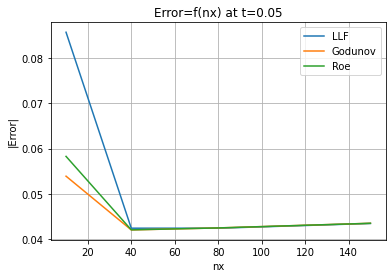

In [7]:
## Inputs
a = -1 ; b = 1 # 1D intervalle a < b
Nx = [10,40,80,150]
dt=0.01
tf=0.5/math.pi**2
#tf=1.5/math.pi**2
print("End time = ",tf)
t = np.arange(0,tf,dt) 
error_nx1=[]
error_nx2=[]
error_nx3=[]
for nx in Nx:
    dx = (b-a) / (nx-1)
    grid = np.linspace(a,b,nx) # creating the space grid         
    u0 = np.zeros(nx)
    uex = np.zeros(nx)
    for i in range(len(grid)):
        u0[i] = - math.cos(math.pi*grid[i]) 
        uex[i] = U(grid[i],tf)
    
    u1 = u0.copy()
    u2 = u0.copy()
    u3 = u0.copy()

    error1=[]
    error2=[]
    error3=[]

    ## Outputs

    frst_schemes(u1, u2, u3, nx, dx, dt, grid, error1, error2, error3)
    error_nx1.append(error1[len(error1)-1])
    error_nx2.append(error2[len(error2)-1])
    error_nx3.append(error3[len(error3)-1])
    
plt.plot(Nx,error_nx1,label='LLF')
plt.plot(Nx,error_nx2,label='Godunov')
plt.plot(Nx,error_nx3,label='Roe')
plt.grid()
plt.legend()
plt.title("Error=f(nx) at t=%1.2f" %tf)
plt.xlabel('nx')
plt.ylabel("|Error|") 

End time =  0.05066059182116889


Text(0, 0.5, '|error|')

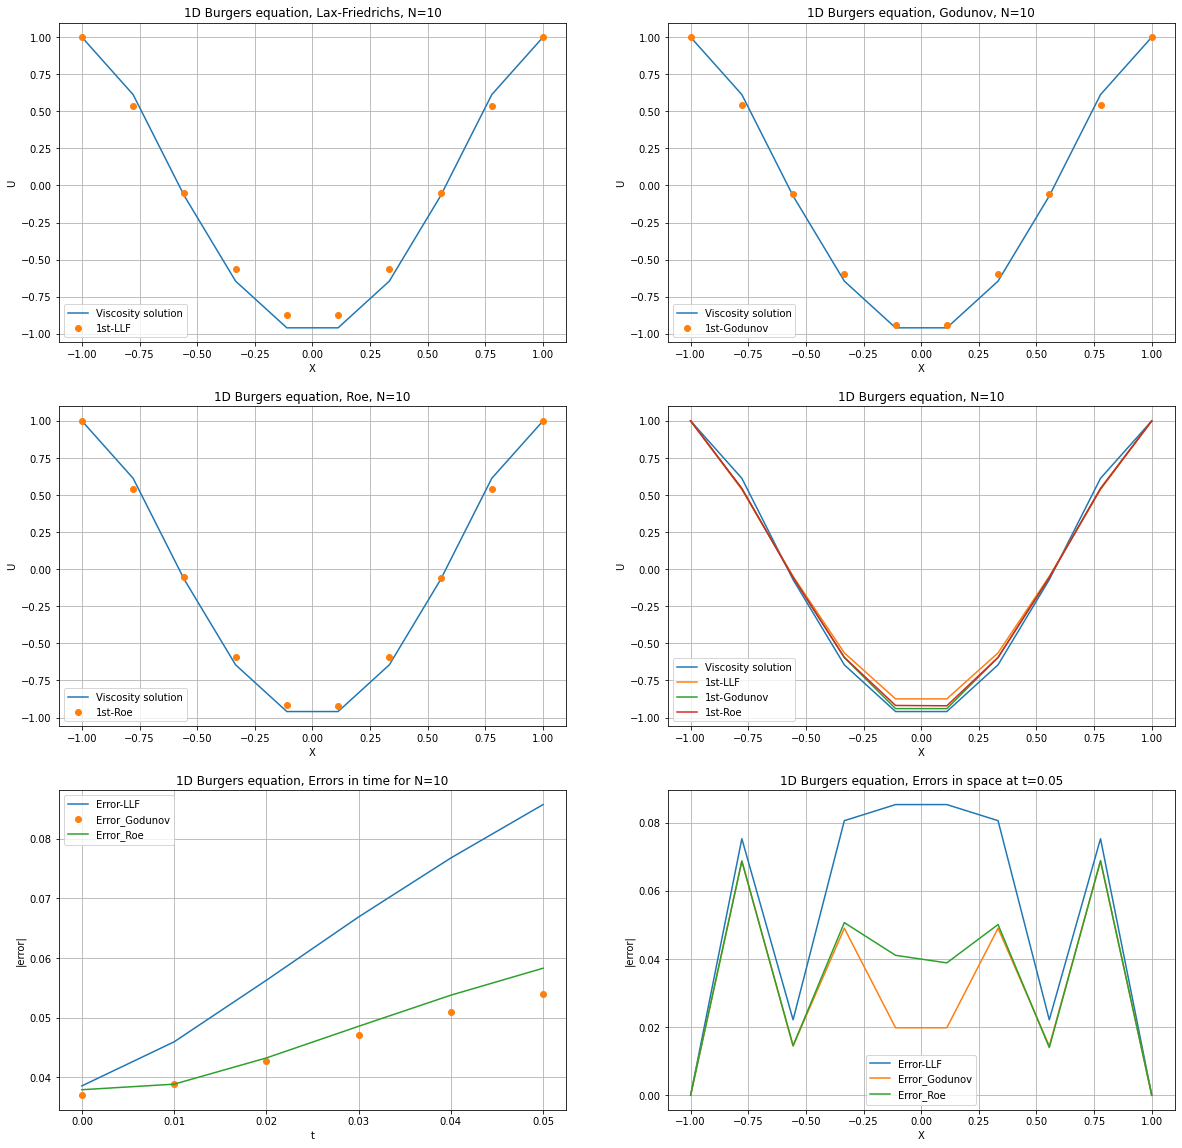

In [8]:
## Inputs
a = -1 ; b = 1 # 1D intervalle a < b
nx = 10
dx = (b-a) / (nx-1)
dt=0.01
tf=0.5/math.pi**2
#tf=1.5/math.pi**2
print("End time = ",tf)
grid = np.linspace(a,b,nx) # creating the space grid  
t = np.arange(0,tf,dt)     
   
u0 = np.zeros(nx)
uex = np.zeros(nx)
for i in range(len(grid)):
    #u0.append(- math.cos(math.pi*grid[i]))
    u0[i] = - math.cos(math.pi*grid[i]) 
    uex[i] = U(grid[i],tf)
    
u1 = u0.copy()
u2 = u0.copy()
u3 = u0.copy()

error1=[]
error2=[]
error3=[]

e1 = np.zeros(nx)
e2 = np.zeros(nx)
e3 = np.zeros(nx)

## Outputs
frst_schemes(u1, u2, u3, nx, dx, dt, grid, error1, error2, error3)

for i in range(len(grid)):
    e1[i]=abs(uex[i]-u1[i])
    e2[i]=abs(uex[i]-u2[i])
    e3[i]=abs(uex[i]-u3[i])


#Plotting data
plt.figure(figsize=(20, 20))
plt.subplot(3,2,1)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,u1,'o',label='1st-LLF')
plt.legend()
#print(u1)
plt.grid()
plt.title("1D Burgers equation, Lax-Friedrichs, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,2)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,u2,'o',label='1st-Godunov')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Godunov, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,3)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,u3,'o',label='1st-Roe')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Roe, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,4)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,u1,label='1st-LLF')
plt.plot(grid,u2,label='1st-Godunov')
plt.plot(grid,u3,label='1st-Roe')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,5)
plt.plot(t,error1,label='Error-LLF')
plt.plot(t,error2,'o',label='Error_Godunov')
plt.plot(t,error3,label='Error_Roe')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Errors in time for N=%1.0f" %nx)
plt.xlabel('t')
plt.ylabel('|error|') 
plt.subplot(3,2,6)
plt.plot(grid,e1,label='Error-LLF')
plt.plot(grid,e2,label='Error_Godunov')
plt.plot(grid,e3,label='Error_Roe')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Errors in space at t=%1.2f" %tf)
#plt.ylim([-1.5,1.5])
plt.xlabel('X')
plt.ylabel('|error|')  

## TVD Schemes

### Number of points

End time =  0.15198177546350666


Text(0, 0.5, '|Error|')

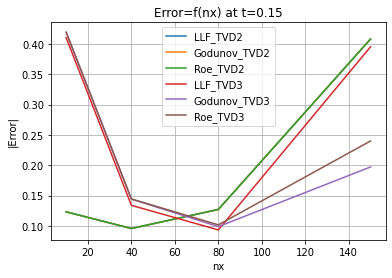

In [17]:
## Inputs
a = -1 ; b = 1 # 1D intervalle a < b
Nx = [10,40,80,150]
dt=0.01
#tf=0.5/math.pi**2
tf=1.5/math.pi**2
print("End time = ",tf)
t = np.arange(0,tf,dt) 
error2_nx1=[]
error2_nx2=[]
error2_nx3=[]
error3_nx1=[]
error3_nx2=[]
error3_nx3=[]
for nx in Nx:
    dx = (b-a) / (nx-1)
    grid = np.linspace(a,b,nx) # creating the space grid         
    u0 = np.zeros(nx)
    uex = np.zeros(nx)
    for i in range(len(grid)):
        u0[i] = - math.cos(math.pi*grid[i]) 
        uex[i] = U(grid[i],tf)
    
    v1 = u0.copy()
    v2 = u0.copy()
    v3 = u0.copy()

    error1_TVD2=[]
    error2_TVD2=[]
    error3_TVD2=[]
    
    w1 = u0.copy()
    w2 = u0.copy()
    w3 = u0.copy()
    
    error1_TVD3=[]
    error2_TVD3=[]
    error3_TVD3=[]

    ## Outputs

    TVD_deg2(v1, v2, v3, nx, dx, dt, grid, error1_TVD2, error2_TVD2, error3_TVD2)
    error2_nx1.append(np.linalg.norm(error1_TVD2[len(error1_TVD2)-1]))
    error2_nx2.append(np.linalg.norm(error2_TVD2[len(error2_TVD2)-1]))
    error2_nx3.append(np.linalg.norm(error3_TVD2[len(error3_TVD2)-1]))
    TVD_deg3(w1, w2, w3, nx, dx, dt, grid, error1_TVD3, error2_TVD3, error3_TVD3)
    error3_nx1.append(np.linalg.norm(error1_TVD3[len(error1_TVD3)-1]))
    error3_nx2.append(np.linalg.norm(error2_TVD3[len(error2_TVD3)-1]))
    error3_nx3.append(np.linalg.norm(error3_TVD3[len(error3_TVD3)-1]))
    
plt.plot(Nx,error2_nx1,label='LLF_TVD2')
plt.plot(Nx,error2_nx2,label='Godunov_TVD2')
plt.plot(Nx,error2_nx3,label='Roe_TVD2')
plt.plot(Nx,error3_nx1,label='LLF_TVD3')
plt.plot(Nx,error3_nx2,label='Godunov_TVD3')
plt.plot(Nx,error3_nx3,label='Roe_TVD3')
plt.grid()
plt.legend()
plt.title("Error=f(nx) at t=%1.2f" %tf)
plt.xlabel('nx')
plt.ylabel("|Error|") 

End time =  0.05066059182116889


Text(0, 0.5, '|error|')

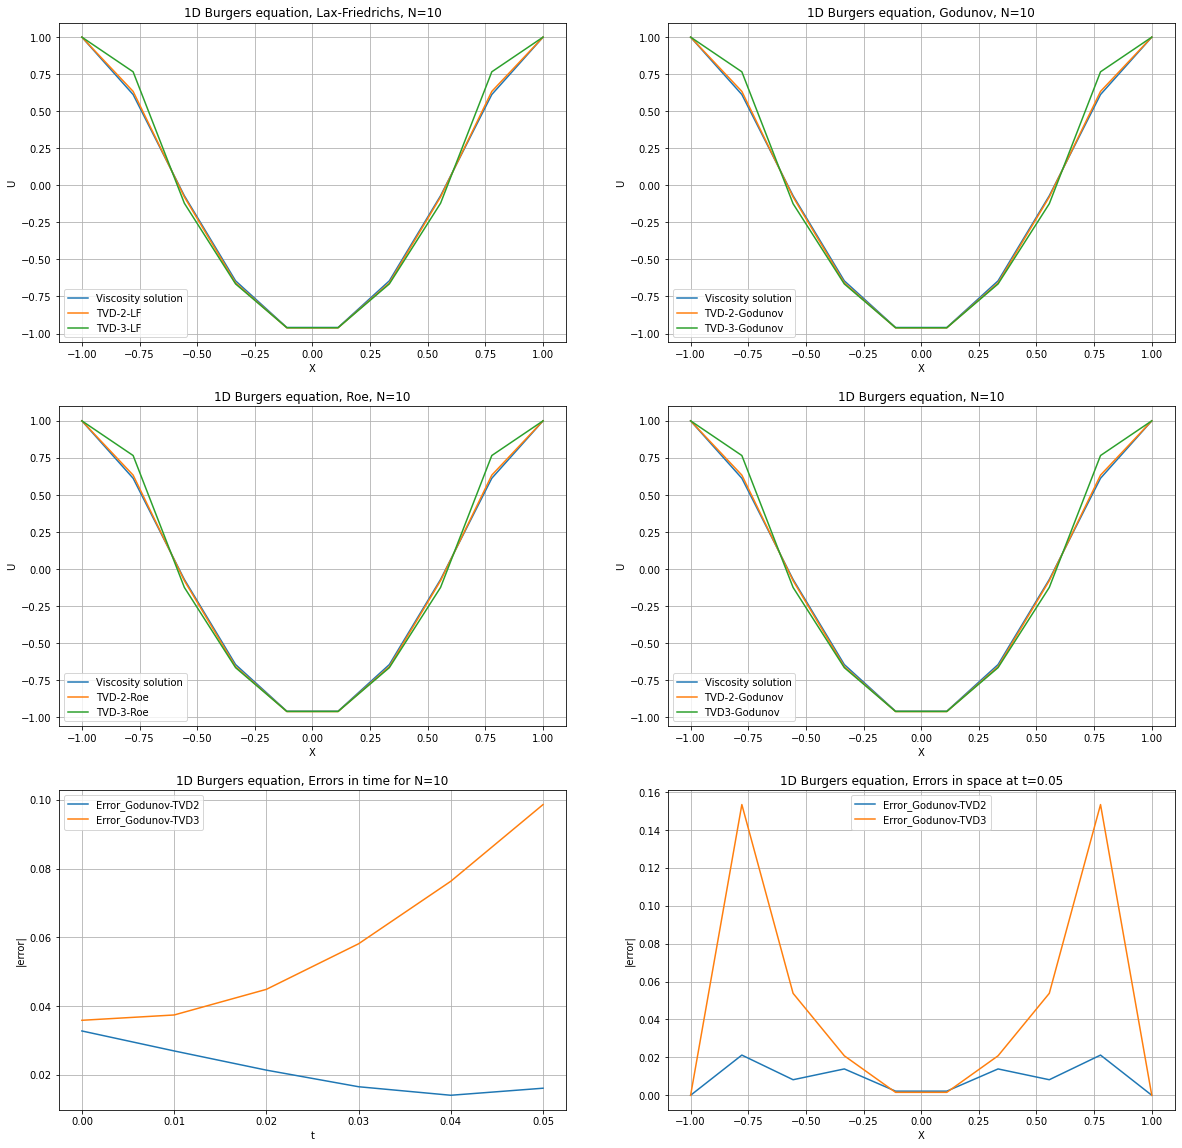

In [10]:
a = -1 ; b = 1 # 1D intervalle a < b
nx = 10
dx = (b-a) / (nx-1)
CFL = 0.25  # CFL <= 1
dt=0.01
tf=0.5/math.pi**2
print("End time = ",tf)
grid = np.linspace(a,b,nx) # creating the space grid  
#t = np.arange(0,tf,dt) #
   
u0 = np.zeros(nx)
uex = np.zeros(nx)
for i in range(len(grid)):
    #u0.append(- math.cos(math.pi*grid[i]))
    u0[i] = - math.cos(math.pi*grid[i])
    uex[i] = U(grid[i],tf)

v1 = u0.copy()
v2 = u0.copy()
v3 = u0.copy()

error1_TVD2=[]
error2_TVD2=[]
error3_TVD2=[]

w1 = u0.copy()
w2 = u0.copy()
w3 = u0.copy()

error1_TVD3=[]
error2_TVD3=[]
error3_TVD3=[]

TVD_deg2(v1, v2, v3, nx, dx, dt, grid, error1_TVD2, error2_TVD2, error3_TVD2)
e1_TVD2 = np.zeros(nx)
e2_TVD2 = np.zeros(nx)
e3_TVD2 = np.zeros(nx)
for i in range(len(grid)):
    e1_TVD2[i]=abs(uex[i]-v1[i])
    e2_TVD2[i]=abs(uex[i]-v2[i])
    e3_TVD2[i]=abs(uex[i]-v3[i])
TVD_deg3(w1, w2, w3, nx, dx, dt, grid, error1_TVD3, error2_TVD3, error3_TVD3)
e1_TVD3 = np.zeros(nx)
e2_TVD3 = np.zeros(nx)
e3_TVD3 = np.zeros(nx)
for i in range(len(grid)):
    e1_TVD3[i]=abs(uex[i]-w1[i])
    e2_TVD3[i]=abs(uex[i]-w2[i])
    e3_TVD3[i]=abs(uex[i]-w3[i])
#Plotting data
plt.figure(figsize=(20, 20))
plt.subplot(3,2,1)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,v1,label='TVD-2-LF')
plt.plot(grid,w1,label='TVD-3-LF')
plt.legend()
#print(u1)
plt.grid()
plt.title("1D Burgers equation, Lax-Friedrichs, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,2)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,v2,label='TVD-2-Godunov')
plt.plot(grid,w2,label='TVD-3-Godunov')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Godunov, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,3)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,v3,label='TVD-2-Roe')
plt.plot(grid,w3,label='TVD-3-Roe')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Roe, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,4)
plt.plot(grid,uex,label='Viscosity solution')
#plt.plot(grid,w1,label='TVD3-LLF')
plt.plot(grid,v2,label='TVD-2-Godunov')
plt.plot(grid,w2,label='TVD3-Godunov')
#plt.plot(grid,w3,label='TVD3-Roe')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,5)
#plt.plot(t,error1_TVD2,label='Error-LLF-TVD2')
plt.plot(t,error2_TVD2,label='Error_Godunov-TVD2')
#plt.plot(t,error3_TVD2,'o',label='Error_Roe-TVD2')
#plt.plot(t,error1_TVD3,label='Error-LLF-TVD3')
plt.plot(t,error2_TVD3,label='Error_Godunov-TVD3')
#plt.plot(t,error3_TVD3,'+',label='Error_Roe-TVD3')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Errors in time for N=%1.0f" %nx)
plt.xlabel('t')
plt.ylabel('|error|') 
plt.subplot(3,2,6)
#plt.plot(grid,e1_TVD2,label='Error-LLF-TVD2')
plt.plot(grid,e2_TVD2,label='Error_Godunov-TVD2')
#plt.plot(grid,e3_TVD2,label='Error_Roe-TVD2')
#plt.plot(grid,e1_TVD3,label='Error-LLF-TVD3')
plt.plot(grid,e2_TVD3,label='Error_Godunov-TVD3')
#plt.plot(grid,e3_TVD3,label='Error_Roe-TVD3')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Errors in space at t=%1.2f" %tf)
#plt.ylim([-1.5,1.5])
plt.xlabel('X')
plt.ylabel('|error|')   

# ENO Schemes

### Number of points

End time =  0.05066059182116889


Text(0, 0.5, '|Error|')

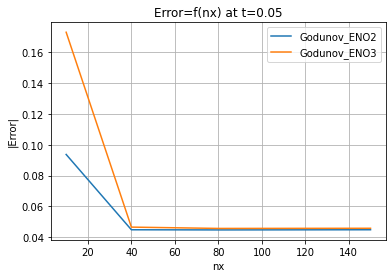

In [11]:
## Inputs
a = -1 ; b = 1 # 1D intervalle a < b
Nx = [10,40,80,150]
dt=0.01
tf=0.5/math.pi**2
#tf=1.5/math.pi**2
print("End time = ",tf)
t = np.arange(0,tf,dt) 
error2_nx1=[]
error2_nx2=[]
error2_nx3=[]
error3_nx1=[]
error3_nx2=[]
error3_nx3=[]
for nx in Nx:
    dx = (b-a) / (nx-1)
    grid = np.linspace(a,b,nx) # creating the space grid         
    u0 = np.zeros(nx)
    uex = np.zeros(nx)
    for i in range(len(grid)):
        u0[i] = - math.cos(math.pi*grid[i]) 
        uex[i] = U(grid[i],tf)
    
    y1 = u0.copy()
    y2 = u0.copy()
    y3 = u0.copy()

    error1_ENO2=[]
    error2_ENO2=[]
    error3_ENO2=[]
    
    z1 = u0.copy()
    z2 = u0.copy()
    z3 = u0.copy()
    
    error1_ENO3=[]
    error2_ENO3=[]
    error3_ENO3=[]

    ## Outputs

    ENO_deg2(y1, y2, y3, nx, dx, dt, grid, error1_ENO2, error2_ENO2, error3_ENO2)
    error2_nx1.append(np.linalg.norm(error1_ENO2[len(error1_ENO2)-1]))
    error2_nx2.append(np.linalg.norm(error2_ENO2[len(error2_ENO2)-1]))
    error2_nx3.append(np.linalg.norm(error3_ENO2[len(error3_ENO2)-1]))
    ENO_deg3(z1, z2, z3, nx, dx, dt, grid, error1_ENO3, error2_ENO3, error3_ENO3)
    error3_nx1.append(np.linalg.norm(error1_ENO3[len(error1_ENO3)-1]))
    error3_nx2.append(np.linalg.norm(error2_ENO3[len(error1_ENO3)-1]))
    error3_nx3.append(np.linalg.norm(error3_ENO3[len(error1_ENO3)-1]))
    
#plt.plot(Nx,error2_nx1,label='LLF_ENO2')
plt.plot(Nx,error2_nx2,label='Godunov_ENO2')
#plt.plot(Nx,error2_nx3,label='Roe_ENO2')
#plt.plot(Nx,error3_nx1,label='LLF_ENO3')
plt.plot(Nx,error3_nx2,label='Godunov_ENO3')
#plt.plot(Nx,error3_nx3,label='Roe_ENO3')
plt.grid()
plt.legend()
plt.title("Error=f(nx) at t=%1.2f" %tf)
plt.xlabel('nx')
plt.ylabel("|Error|") 

End time =  0.05066059182116889


Text(0, 0.5, '|error|')

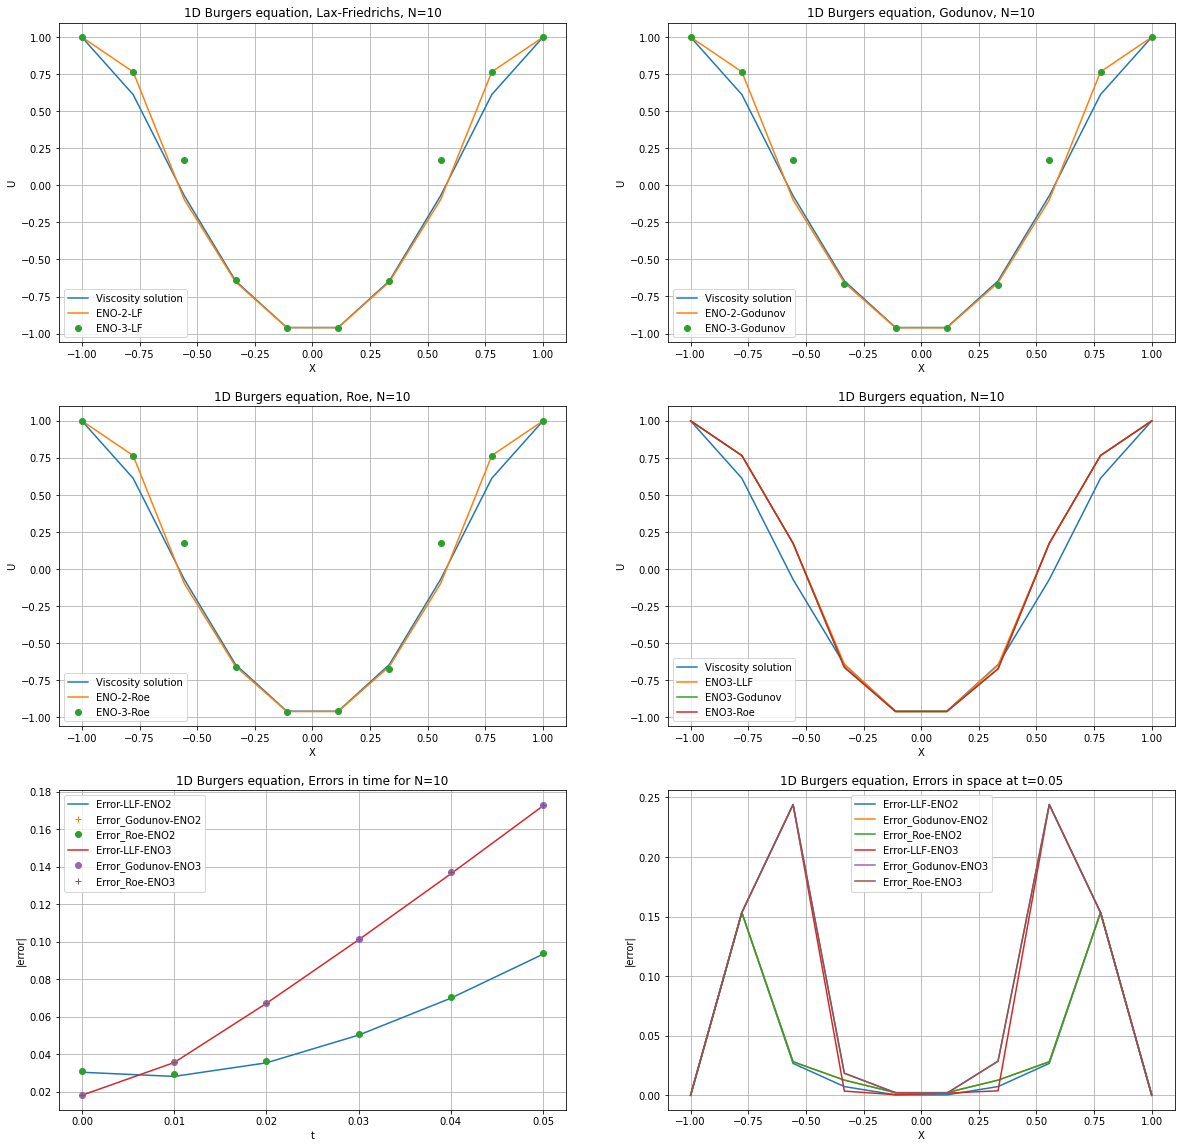

In [12]:
a = -1 ; b = 1 # 1D intervalle a < b
nx = 10
dx = (b-a) / (nx-1)
CFL = 0.25  # CFL <= 1
dt=0.01
tf=0.5/math.pi**2
print("End time = ",tf)
grid = np.linspace(a,b,nx) # creating the space grid  
#t = np.arange(0,tf,dt) #
   
u0 = np.zeros(nx)
uex = np.zeros(nx)
for i in range(len(grid)):
    #u0.append(- math.cos(math.pi*grid[i]))
    u0[i] = - math.cos(math.pi*grid[i]) 
    uex[i] = U(grid[i],tf)
    
y1 = u0.copy()
y2 = u0.copy()
y3 = u0.copy()

error1_ENO2=[]
error2_ENO2=[]
error3_ENO2=[]

z1 = u0.copy()
z2 = u0.copy()
z3 = u0.copy()

error1_ENO3=[]
error2_ENO3=[]
error3_ENO3=[]

ENO_deg2(y1, y2, y3, nx, dx, dt, grid, error1_ENO2, error2_ENO2, error3_ENO2)
e1_ENO2 = np.zeros(nx)
e2_ENO2 = np.zeros(nx)
e3_ENO2 = np.zeros(nx)
for i in range(len(grid)):
    e1_ENO2[i]=abs(uex[i]-y1[i])
    e2_ENO2[i]=abs(uex[i]-y2[i])
    e3_ENO2[i]=abs(uex[i]-y3[i])
ENO_deg3(z1, z2, z3, nx, dx, dt, grid, error1_ENO3, error2_ENO3, error3_ENO3)
e1_ENO3 = np.zeros(nx)
e2_ENO3 = np.zeros(nx)
e3_ENO3 = np.zeros(nx)
for i in range(len(grid)):
    e1_ENO3[i]=abs(uex[i]-z1[i])
    e2_ENO3[i]=abs(uex[i]-z2[i])
    e3_ENO3[i]=abs(uex[i]-z3[i])
#Plotting data
plt.figure(figsize=(20, 20))
plt.subplot(3,2,1)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,y1,label='ENO-2-LF')
plt.plot(grid,z1,'o',label='ENO-3-LF')
plt.legend()
#print(u1)
plt.grid()
plt.title("1D Burgers equation, Lax-Friedrichs, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,2)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,y2,label='ENO-2-Godunov')
plt.plot(grid,z2,'o',label='ENO-3-Godunov')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Godunov, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,3)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,y3,label='ENO-2-Roe')
plt.plot(grid,z3,'o',label='ENO-3-Roe')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Roe, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,4)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,z1,label='ENO3-LLF')
plt.plot(grid,z2,label='ENO3-Godunov')
plt.plot(grid,z3,label='ENO3-Roe')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,5)
plt.plot(t,error1_ENO2,label='Error-LLF-ENO2')
plt.plot(t,error2_ENO2,'+',label='Error_Godunov-ENO2')
plt.plot(t,error3_ENO2,'o',label='Error_Roe-ENO2')
plt.plot(t,error1_ENO3,label='Error-LLF-ENO3')
plt.plot(t,error2_ENO3,'o',label='Error_Godunov-ENO3')
plt.plot(t,error3_ENO3,'+',label='Error_Roe-ENO3')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Errors in time for N=%1.0f" %nx)
plt.xlabel('t')
plt.ylabel('|error|') 
plt.subplot(3,2,6)
plt.plot(grid,e1_ENO2,label='Error-LLF-ENO2')
plt.plot(grid,e2_ENO2,label='Error_Godunov-ENO2')
plt.plot(grid,e3_ENO2,label='Error_Roe-ENO2')
plt.plot(grid,e1_ENO3,label='Error-LLF-ENO3')
plt.plot(grid,e2_ENO3,label='Error_Godunov-ENO3')
plt.plot(grid,e3_ENO3,label='Error_Roe-ENO3')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Errors in space at t=%1.2f" %tf)
#plt.ylim([-1.5,1.5])
plt.xlabel('X')
plt.ylabel('|error|')  

## WENO Schemes

### Number of points

End time =  0.05066059182116889


Text(0, 0.5, '|Error|')

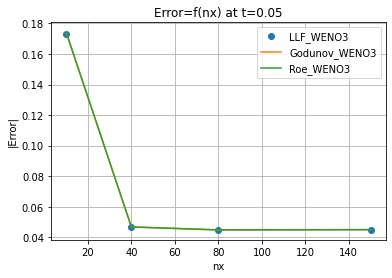

In [13]:
## Inputs
a = -1 ; b = 1 # 1D intervalle a < b
Nx = [10,40,80,150]
dt=0.01
tf=0.5/math.pi**2
#tf=1.5/math.pi**2
print("End time = ",tf)
t = np.arange(0,tf,dt) 
error_nx1=[]
error_nx2=[]
error_nx3=[]
for nx in Nx:
    dx = (b-a) / (nx-1)
    grid = np.linspace(a,b,nx) # creating the space grid         
    u0 = np.zeros(nx)
    uex = np.zeros(nx)
    for i in range(len(grid)):
        u0[i] = - math.cos(math.pi*grid[i]) 
        uex[i] = U(grid[i],tf)
    
    s1 = u0.copy()
    s2 = u0.copy()
    s3 = u0.copy()

    error1_WENO3=[]
    error2_WENO3=[]
    error3_WENO3=[]

    ## Outputs

    WENO_deg3(s1, s2, s3, nx, dx, dt, grid, error1_WENO3, error2_WENO3, error3_WENO3)
    error_nx1.append(np.linalg.norm(error1_WENO3[len(error1_WENO3)-1]))
    error_nx2.append(np.linalg.norm(error2_WENO3[len(error2_WENO3)-1]))
    error_nx3.append(np.linalg.norm(error3_WENO3[len(error3_WENO3)-1]))
    
plt.plot(Nx,error_nx1,'o',label='LLF_WENO3')
plt.plot(Nx,error_nx2,label='Godunov_WENO3')
plt.plot(Nx,error_nx3,label='Roe_WENO3')
plt.grid()
plt.legend()
plt.title("Error=f(nx) at t=%1.2f" %tf)
plt.xlabel('nx')
plt.ylabel("|Error|") 

End time =  0.05066059182116889


Text(0, 0.5, '|error|')

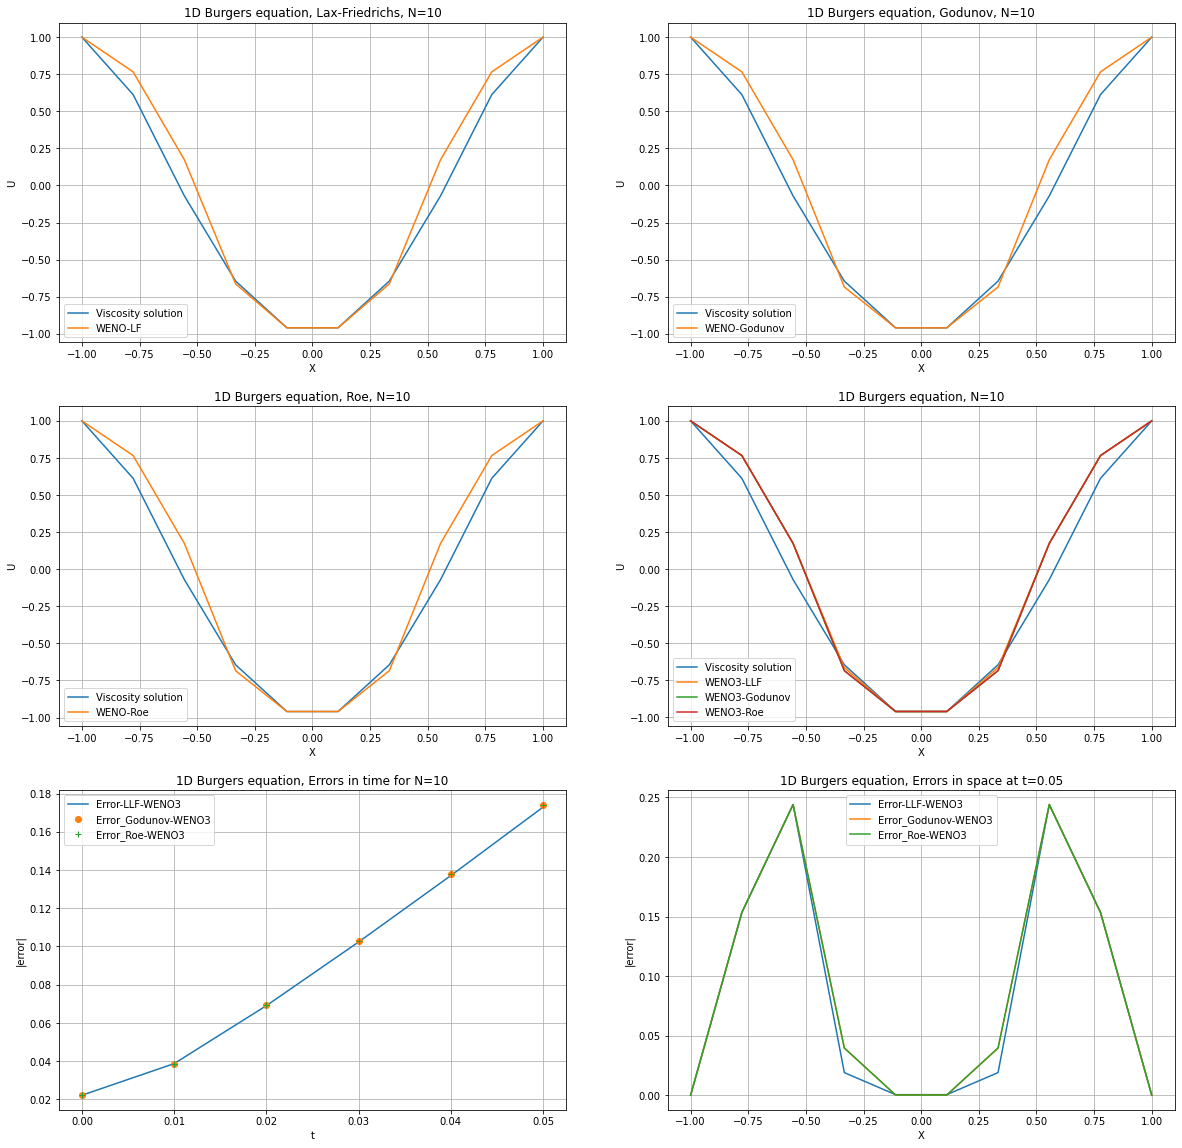

In [14]:
a = -1 ; b = 1 # 1D intervalle a < b
nx = 10
dx = (b-a) / (nx-1)
CFL = 0.25  # CFL <= 1
dt=0.01
tf=0.5/math.pi**2
print("End time = ",tf)
grid = np.linspace(a,b,nx) # creating the space grid  
#t = np.arange(0,tf,dt) #
   
u0 = np.zeros(nx)
uex = np.zeros(nx)
for i in range(len(grid)):
    #u0.append(- math.cos(math.pi*grid[i]))
    u0[i] = - math.cos(math.pi*grid[i]) 
    uex[i] = U(grid[i],tf)
    
s1 = u0.copy()
s2 = u0.copy()
s3 = u0.copy()

error1_WENO3=[]
error2_WENO3=[]
error3_WENO3=[]

WENO_deg3(s1, s2, s3, nx, dx, dt, grid, error1_WENO3, error2_WENO3, error3_WENO3)
e1_WENO3 = np.zeros(nx)
e2_WENO3 = np.zeros(nx)
e3_WENO3 = np.zeros(nx)
for i in range(len(grid)):
    e1_WENO3[i]=abs(uex[i]-s1[i])
    e2_WENO3[i]=abs(uex[i]-s2[i])
    e3_WENO3[i]=abs(uex[i]-s3[i])
#Plotting data
plt.figure(figsize=(20, 20))
plt.subplot(3,2,1)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,s1,label='WENO-LF')
plt.legend()
#print(u1)
plt.grid()
plt.title("1D Burgers equation, Lax-Friedrichs, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,2)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,s2,label='WENO-Godunov')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Godunov, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,3)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,s3,label='WENO-Roe')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Roe, N=%1.0f" %nx)
#plt.ylim([-1.5,1.5])
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,4)
plt.plot(grid,uex,label='Viscosity solution')
plt.plot(grid,s1,label='WENO3-LLF')
plt.plot(grid,s2,label='WENO3-Godunov')
plt.plot(grid,s3,label='WENO3-Roe')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, N=%1.0f" %nx)
plt.xlabel('X')
plt.ylabel('U')
plt.subplot(3,2,5)
plt.plot(t,error1_WENO3,label='Error-LLF-WENO3')
plt.plot(t,error2_WENO3,'o',label='Error_Godunov-WENO3')
plt.plot(t,error3_WENO3,'+',label='Error_Roe-WENO3')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Errors in time for N=%1.0f" %nx)
plt.xlabel('t')
plt.ylabel('|error|') 
plt.subplot(3,2,6)
plt.plot(grid,e1_WENO3,label='Error-LLF-WENO3')
plt.plot(grid,e2_WENO3,label='Error_Godunov-WENO3')
plt.plot(grid,e3_WENO3,label='Error_Roe-WENO3')
plt.legend()
#print(u2)
plt.grid()
plt.title("1D Burgers equation, Errors in space at t=%1.2f" %tf)
#plt.ylim([-1.5,1.5])
plt.xlabel('X')
plt.ylabel('|error|')  